# CatBoost Encoder: uma alternativa (interessante) aos métodos tradicionais de encoding  
<br></br>

![cat image](https://cdn.theatlantic.com/thumbor/A9iv2yRXo4Tydbm4f4WD9UGOQGg=/0x0:4800x2700/976x549/media/img/mt/2022/09/Cat_purr_1/original.jpg)  

<br></br>
## 1) Visão Geral
Todo Cientista de Dados já se deparou com a seguinte dúvida: **como devo lidar com variáveis categóricas?**. As soluções mais utilizadas na prática consistem em convertê-las em variáveis numéricas de modo que os principais algoritmos de Machine Learning possam ser aplicados. *One hot encoding*, *Target encoder* e *Weight Of Evidence Encoding* são algumas das alternativas mais populares. Mas afinal, o que são variáveis categóricas?  
  
<br></br>
Variáveis categóricas são aquelas que indicam uma característica não numérica, como uma marca automotiva, a cor de um produto, gênero de um filme ou a classe de um medicamento. Podem ser divididas em dois grupos:  
<br></br>
>- **Nominais**: Quando não existe uma hierarquia entre os valores. Por exemplo, se estamos modelando um algoritmo para estimar os preços de carros populares, podemos considerar que a cor do automóvel não impacta (será?) nos preços de venda.  
<br></br>
>- **Ordinárias**: Quando existe uma hierarquia entre os dados. Por exemplo, estágios de uma doença. Um paciente graduado no estágio D possui prognóstico pior que um graduado no estágio A, por exemplo. Logo, existe uma ordem entre o espectro da patologia, e seria interessante que o algoritmo de Machine Learning entenda isso.  

<br></br>
O objetivo desse artigo é apresentar as principais desvantagens destes 3 métodos de Encoding de variáveis categóricas e apresentar uma alternativa (CatBoost Encoder) comparando seus resultados com as técnicas tradicionais em uma mesma base de dados. Para esse artigo, foi escolhido o dataset [Categorical Feature Encoding Challenge](https://www.kaggle.com/c/cat-in-the-dat) do Kaggle. Essa base de dados possui apenas variáveis independentes categóricas, sendo portanto um bom exemplo para comparar as técnicas de encoding.
<br></br>

### 1.1) Prós e contras dos métodos tradicionais de Encoding
*One-hot-encoding* é a técnica mais utilizada para transformar variáveis categóricas em numéricas. Ela converte variáveis categorias em vetores numéricos, ou seja, se uma coluna possui cardinalidade (número de valores distintos) $k$ e a base de dados tem dimensão $mxn$, após o One hot encoding, tem-se um dataset de dimensões $mx(n+k)$. A principal desvantagem é o aumento da dimensionalidade dos dados (tema para outro artigo), pois $k$ novas colunas serão criadas para indicar a presença ou ausência de cada categoria específica.
<br></br>

Uma alternativa à esse problema é utilizar um método de encoding que não aumente a dimensionalidade dos dados. *Target Encoding* consiste em substituir cada classe por sua frequência de aparecimento no alvo. Por exemplo, se a cor verde aparece 3 vezes quando o alvo é $1$ e a vermelho duas, verde será substituido por **0,6** e vermelho **0,4**. A grande desvantagem dessa técnica de encoding é o *Target Leakage*. Isto é um grande problema, pois insere-se dados do alvo na base em que o algoritmo de Machine Learning será treinado.
<br></br>

Outro método de encoding que tenta contornar essas desvantagens é o *Weight of Evidence (WOE)*. Sua definição matemática se baseia no logaritmo natural do *Odds Ratio (OR)* da frequência com que a classe aparece no alvo. 
<br></br>
$$ln = Freq(eventos) / Freq(não - eventos)$$  
Ou seja, quanto maior o WOE, maior a probabiliade daquele evento (valor) ocorrer. A grande vantagem do WOE é estabelecer uma relação monotônica (função que progride em apenas uma direção) entre as variáveis independentes e o alvo. 

### 1.2) A idéia por trás do CatBoost Encoder  
Como explicado acima, seria interessante que um método de *encoding* unisse o útil ao agradável: não gerar aumento de dimensionalidade desnecessário, não criar ordenamento em variáveis nominais e não introduzir vazamento de dados da variável alvo. CatBoost Encoder preenche esses 3 critérios!  
<br></br>

A idéia principal desse algoritmo é fazer o encoding de forma sequencial. Assim como é feita a validação em um problema de séries temporais, o CatBoost Encoder percorre a base de dados de modo progressivo, estimando por etapas a frequência de cada classe. Dessa forma, as frequências dos registros avaliados primeiro adquirem variância maior, já que a o algoritmo ainda verificou poucos registros. Contudo, a medida que o CatBoost percorre a base de dados, as frequências iniciais são atualizadas de modo recorrênte, por meio da média do valor de cada classe na base toda.
<br></br>

## 2) Prática...  
Em tese, esse processo de encoding iterativo soluciona o problema do Target Leakage, já que as frequências são atualizadas de maneira sucessiva. Vejamos agora como isso funciona na prática. Como o foco deste artigo não é realizar uma análise exploratória de dados (EDA) detalhada, fui o mais breve possível nessa etapa e parti diretamente para a comparação dos métodos.
<br></br>

Para isso, abaixo instalo a biblioteca category_encoders, que possui a implementação do CatBoost Encoder, importo as bibliotecas e carrego a base de dados train.csv do link disponibilizado acima.

In [1]:
# pip install category-encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 KB 342.0 kB/s eta 0:00:00 eta 0:00:01
You should consider upgrading via the '/home/joseraposo/miniconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Algebra linear e dataframes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Métodos de encoding tradicionais
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Encoders
from category_encoders import TargetEncoder, WOEEncoder
from category_encoders.cat_boost import CatBoostEncoder

# Pipeline 
from sklearn.pipeline import Pipeline

# Algoritmos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from catboost import CatBoostClassifier

# Métrica alvo da competição
from sklearn.metrics import roc_auc_score

%matplotlib inline
pd.set_option('display.max_columns', 50)
import gc

Abaixo, carrego a base de dados previamente convertida em Parquet, por questões de otimização de memória local:

In [2]:
df = pd.read_parquet('train.parquet')
df.head(3)

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   bin_0   300000 non-null  int64 
 1   bin_1   300000 non-null  int64 
 2   bin_2   300000 non-null  int64 
 3   bin_3   300000 non-null  object
 4   bin_4   300000 non-null  object
 5   nom_0   300000 non-null  object
 6   nom_1   300000 non-null  object
 7   nom_2   300000 non-null  object
 8   nom_3   300000 non-null  object
 9   nom_4   300000 non-null  object
 10  nom_5   300000 non-null  object
 11  nom_6   300000 non-null  object
 12  nom_7   300000 non-null  object
 13  nom_8   300000 non-null  object
 14  nom_9   300000 non-null  object
 15  ord_0   300000 non-null  int64 
 16  ord_1   300000 non-null  object
 17  ord_2   300000 non-null  object
 18  ord_3   300000 non-null  object
 19  ord_4   300000 non-null  object
 20  ord_5   300000 non-null  object
 21  day     300000 non-null  int64 
 

Precisamos converter as colunas do tipo int64 para object. Afinal, embora representadas por números, na verdade tratam-se de variáveis categóricas! Para isso, criamos uma função lambda simples.

In [4]:
def convert_type(dataframe):
    df = dataframe.copy()
    for col in df.columns[:-1]:
        if df[col].dtypes == 'int64':
            df[col] = df[col].astype('object')
    return df

In [5]:
df = convert_type(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   bin_0   300000 non-null  object
 1   bin_1   300000 non-null  object
 2   bin_2   300000 non-null  object
 3   bin_3   300000 non-null  object
 4   bin_4   300000 non-null  object
 5   nom_0   300000 non-null  object
 6   nom_1   300000 non-null  object
 7   nom_2   300000 non-null  object
 8   nom_3   300000 non-null  object
 9   nom_4   300000 non-null  object
 10  nom_5   300000 non-null  object
 11  nom_6   300000 non-null  object
 12  nom_7   300000 non-null  object
 13  nom_8   300000 non-null  object
 14  nom_9   300000 non-null  object
 15  ord_0   300000 non-null  object
 16  ord_1   300000 non-null  object
 17  ord_2   300000 non-null  object
 18  ord_3   300000 non-null  object
 19  ord_4   300000 non-null  object
 20  ord_5   300000 non-null  object
 21  day     300000 non-null  object
 

Em seguida, após converter os tipos de variáveis categóricas para object, devemos dividir a base de dados em base de treino e teste. A base de treino (70%) será usada tanto para treino quanto para validação dos modelos utilizados. Para cada modelo, comparo a AUROC de 3 pipelines distintos: One-hot-encoding + Modelo, Label encoder + Modelo e CatBoost Encoder + Modelo.  
<br></br>
> Antes disso, é imprescindível verificar a distribuição da variável alvo em busca desproporção entre os alvos. Isso é importante pois nos indica se devemos fazer um split estratificado ou não. 

In [6]:
df.target.value_counts(normalize=True)*100

0    69.412
1    30.588
Name: target, dtype: float64

Como existe desbalanceamento na base, é prudente realizar o split da base de treino e de teste de maneira estratificada, ou seja, mantendo a proporção entre o alvo $0$ e $1$ no subset de treinamento dos modelos e de teste.

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop('target', axis = 1), df.target,
                                               test_size = .5, random_state = 2022, stratify = df.target)

In [8]:
del df
gc.collect()

84

In [122]:
# filtrando warnings -  use com cautela!
import warnings
warnings.filterwarnings('ignore')

# definindo os objetos dos encoders e dos modelos
ohe = OneHotEncoder(handle_unknown = 'ignore')
te = TargetEncoder(handle_unknown = 'ignore', handle_missing='value')
woe = WOEEncoder(handle_unknown = 'ignore')
cbe = CatBoostEncoder(random_state = 2022, handle_unknown = 'ignore')

# dicionário de encoders
dict_encoders = {'One Hot Encoder': ohe, 'Target Encoder': te, 'WOE encoder': woe, 'CatBoost Encoder': cbe}

# modelos de ML
lr = LogisticRegression(random_state = 2022, max_iter = 5000)
dt = DecisionTreeClassifier(criterion='gini', random_state = 2022, max_depth = 5)
rf = RandomForestClassifier(random_state = 2022, max_depth = 5)
cat = CatBoostClassifier(random_seed = 2022, max_depth = 5, verbose = False)

# lista de modelos
dict_modelos = {'Logistic Reg': lr, 'Decision Tree': dt, 'Random Forest': rf, 'CatBoost': cat}

In [11]:
def validate_models(X, y):
    # definindo os datasets
    Xtrain = X.copy()
    ytrain = y.copy()
    
    # para cada encoder...
    for enc_name, enc in dict_encoders.items():
        # para cada algoritmo...
        for model_name, model in dict_modelos.items():
            # defino cada pipeline...
            pipe = Pipeline([(f'{enc_name}', enc),('SI', SimpleImputer(strategy='most_frequent')), 
                                                   (f'{model_name}', model)])
            scores = cross_val_score(pipe, Xtrain, ytrain, cv = 3, scoring = 'roc_auc')
            media = np.mean(scores)
            std = np.std(scores)
            print(f'{enc_name} + {model_name} Mean AUROC:{media}. STD AUROC:{std}')
    return 50*'='

In [12]:
# selecionango o melhor pipeline
validate_models(Xtrain, ytrain)

One Hot Encoder + Logistic Reg Mean AUROC:0.7844207866092363. STD AUROC:0.0012478793593643377
One Hot Encoder + Decision Tree Mean AUROC:0.6411876331642936. STD AUROC:0.0014111762296416775
One Hot Encoder + Random Forest Mean AUROC:0.7274688950448539. STD AUROC:0.007444996518322443
One Hot Encoder + CatBoost Mean AUROC:0.7725752134402292. STD AUROC:0.0022961726314587906
Target Encoder + Logistic Reg Mean AUROC:0.7564255859490162. STD AUROC:0.001825351481888782
Target Encoder + Decision Tree Mean AUROC:0.5981932729940435. STD AUROC:0.002442384617085875
Target Encoder + Random Forest Mean AUROC:0.670838920847704. STD AUROC:0.0019957560510435865
Target Encoder + CatBoost Mean AUROC:0.7383863286631712. STD AUROC:0.002311628389284941
WOE encoder + Logistic Reg Mean AUROC:0.7582953078157519. STD AUROC:0.0017640100216154639
WOE encoder + Decision Tree Mean AUROC:0.5931300515919594. STD AUROC:0.0037424882704039436
WOE encoder + Random Forest Mean AUROC:0.671361519497751. STD AUROC:0.0024248048

'=================================================='

Agora, vejamos os melhores algoritmos comparando os resultados de ROC AUC por técnica de Encoding.

In [101]:
resultados = {
    'OHE': {'Logistic Regression': 78.4, 'Random Forest': 72.7, 'CatBoost': 77.2},
    'TE': {'Logistic Regression': 75.6, 'Random Forest': 67.0, 'CatBoost': 73.8},
    'WOE': {'Logistic Regression': 75.8, 'Random Forest': 67.1, 'CatBoost': 75.1},
    'CatBoost Encoder': {'Logistic Regression': 78.6, 'Random Forest': 74.2, 'CatBoost': 78.7}
}

tmpdf = pd.DataFrame(resultados)

''

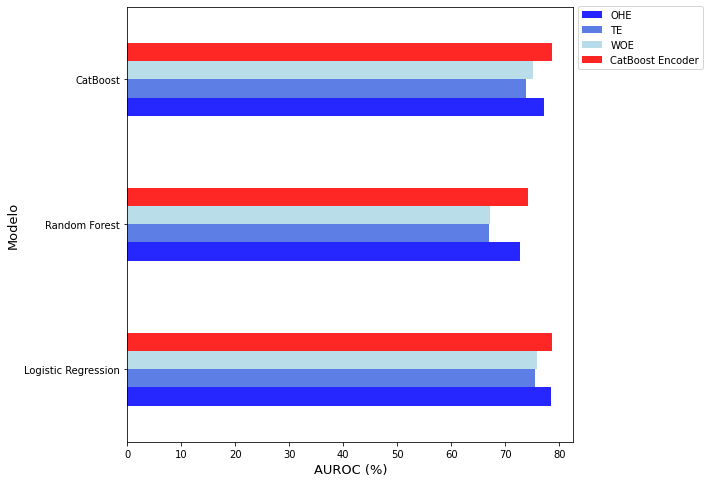

In [104]:
# barplot
tmpdf.plot(kind = 'barh', color = ['blue','royalblue', 'lightblue','red'], figsize=[8,8], alpha = .85)
plt.ylabel('Modelo', size = 13)
plt.xlabel('AUROC (%)', size = 13)
plt.legend(loc='center left', bbox_to_anchor=(1, .929));

###### Conforme a figura apresenta, os pipelines que utilizaram CatBoost Encoder apresentaram uma AUROC discretamente acima quando comparados aos métodos de *encoging* tradicionais, para todos os modelos de Machine Learning avaliados.
<br></br>

Além disso, o Pipeline de melhor desempenho considerando a métrica AUROC de validação foi o CatBoost Encoder + CatBoost. Vamos então usá-lo na base de dados de teste e verificar se a métrica se mantém próxima do resultado obtido. Para isso, criamos o pipeline, treinamos na base de treino completa e em seguida realizamos as predições na base de testes e comparando ambas.

In [131]:
# pipeline vitorioso
pipe = Pipeline([('CatBoost Encoder', cbe),('SI', SimpleImputer(strategy='most_frequent')),('CatBoostClassifier', cat)])
pipe

Pipeline(steps=[('CatBoost Encoder',
                 CatBoostEncoder(handle_unknown='ignore', random_state=2022)),
                ('SI', SimpleImputer(strategy='most_frequent')),
                ('CatBoostClassifier',
                 <catboost.core.CatBoostClassifier object at 0x7ff5eacfbf70>)])

In [132]:
# treinando o pipeline na base de treinamento
pipe.fit(Xtrain, ytrain)

Pipeline(steps=[('CatBoost Encoder',
                 CatBoostEncoder(cols=['bin_0', 'bin_1', 'bin_2', 'bin_3',
                                       'bin_4', 'nom_0', 'nom_1', 'nom_2',
                                       'nom_3', 'nom_4', 'nom_5', 'nom_6',
                                       'nom_7', 'nom_8', 'nom_9', 'ord_0',
                                       'ord_1', 'ord_2', 'ord_3', 'ord_4',
                                       'ord_5', 'day', 'month'],
                                 handle_unknown='ignore', random_state=2022)),
                ('SI', SimpleImputer(strategy='most_frequent')),
                ('CatBoostClassifier',
                 <catboost.core.CatBoostClassifier object at 0x7ff5eacfbf70>)])

In [133]:
# realizando predições na base out of sample
predicoes = pipe.predict(Xtest)

In [134]:
print('AUROC base de Teste:', roc_auc_score(ytest, predicoes))

AUROC base de Teste: 0.6665382702341883


## 3) Finalizando
Como podemos ver acima, houve uma queda relevante de AUROC entre a métrica de validação e a métrica de teste. Isso pode ter acontecido por diversas razões, dentre elas, *data drift*, mudanças da distribuição das variáveis independentes ao longo do tempo, *overfitting* do algoritmo, escolha inadequada do método de validação e até mesmo falha na montagem da base de dados (bem menos provável nesse caso). Esses são ótimos temas para aprofundarmos em próximos artigos.
<br></br>

Portanto, como o objetivo deste artigo não foi atingir o melhor modelo possível para essa base em específico, somos tolerantes com essa discrepância de métrica. Meu objetivo principal foi apresentar uma nova ferramenta de *encoding* de variáveis categóricas mostrando a idéia principal por trás do método e em que situações ela pode ser usada na sua rotina de modelagem. 
<br></br>

*Se esse artigo foi útil para você, peço que deixe seu like e um comentário. Estou aberto à dúvidas e contribuições. Você pode entrar em contato comigo nos endereços abaixo:*
<br></br>

> - **LinkedIn**: https://www.linkedin.com/in/jose-neto1/
> - **GitHub**: https://github.com/jose-raposo
<br></br>

**Referências:**  
1. https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic  
2. https://www.geeksforgeeks.org/categorical-encoding-with-catboost-encoder/  
3. https://contrib.scikit-learn.org/category_encoders/catboost.html